In [4]:
import pandas as pd
import numpy as np
import os, re
from tqdm import tqdm 
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [5]:
files = list(filter(
    lambda x: '.feather' in x,
    os.listdir()))

In [6]:
data = {f: pd.read_feather(f).set_index('Unnamed: 0') for f in tqdm(files) if '.feather' in f}


100%|██████████| 148/148 [04:06<00:00,  1.66s/it]


In [7]:
for f, df in tqdm(data.items()):
    df['singular_grammaticality'] = df.candidate2_base_prob / df.candidate1_base_prob
    df['plural_grammaticality']   = df.candidate1_alt1_prob / df.candidate2_alt1_prob
    df['inv_singular_grammaticality'] = 1 / df.singular_grammaticality
    df['inv_plural_grammaticality']   = 1 / df.plural_grammaticality
    df['yz'] = df.candidate2_prob / df.candidate1_prob
    df['effect'] = df.yz / df.singular_grammaticality - 1
    df['total_effect'] = 1 / (df.plural_grammaticality * df.singular_grammaticality) - 1


100%|██████████| 148/148 [00:56<00:00,  2.60it/s]


In [8]:
data_agg  = {}
data_top5 = {}
cols = [
    'neuron', 'layer', 
    'effect', 
    'singular_grammaticality', 'plural_grammaticality', 
    'inv_singular_grammaticality', 'inv_plural_grammaticality',
    'total_effect',
]
for f, df in tqdm(data.items()):
    agg = (
        df[cols].groupby(['layer', 'neuron'])
        .agg(['mean', 'std', 'sem']))
    agg.columns = ['_'.join(col) for col in agg.columns]
    data_agg[f] = agg
    data_top5[f] = (
        agg.sort_values('effect_mean')      # Sort
        .groupby('layer')                   # Get layers
        .tail(int(agg.index.max()[1]*0.05)) # Take top 5%
        .index)                             # Get indices of top 5% by layer


100%|██████████| 148/148 [05:46<00:00,  2.34s/it]


In [9]:
data_agg[f]

effect_mean  effect_std  effect_sem  \
layer neuron                                        
0     0          0.000028    0.010773    0.000762   
      1          0.000162    0.012113    0.000856   
      2          0.001108    0.015434    0.001091   
      3         -0.000280    0.011095    0.000785   
      4         -0.000640    0.006933    0.000490   
...                   ...         ...         ...   
12    763       -0.000042    0.002060    0.000146   
      764       -0.000420    0.002223    0.000157   
      765       -0.000193    0.003277    0.000232   
      766       -0.000225    0.002451    0.000173   
      767        0.000165    0.001744    0.000123   

              singular_grammaticality_mean  singular_grammaticality_std  \
layer neuron                                                              
0     0                            2.06634                     1.759389   
      1                            2.06634                     1.759389   
      2                            2.06634                     1.759389   
      3                            2.06634                     1.759389   
      4                            2.06634                     1.759389   
...                                    ...                          ...   
12    763                          2.06634                     1.759389   
      764                          2.06634                     1.759389   
      765                          2.06634                     1.759389   
      766                          2.06634                     1.759389   
      767                          2.06634                     1.759389   

              singular_grammaticality_sem  plural_grammaticality_mean  \
layer neuron                                                            
0     0                          0.124408                    1.249222   
      1                          0.124408                    1.249222   
      2                          0.124408                    1.249222   
      3                          0.124408                    1.249222   
      4                          0.124408                    1.249222   
...                                   ...                         ...   
12    763                        0.124408                    1.249222   
      764                        0.124408                    1.249222   
      765                        0.124408                    1.249222   
      766                        0.124408                    1.249222   
      767                        0.124408                    1.249222   

              plural_grammaticality_std  plural_grammaticality_sem  \
layer neuron                                                         
0     0                        1.656057                   0.117101   
      1                        1.656057                   0.117101   
      2                        1.656057                   0.117101   
      3                        1.656057                   0.117101   
      4                        1.656057                   0.117101   
...                                 ...                        ...   
12    763                      1.656057                   0.117101   
      764                      1.656057                   0.117101   
      765                      1.656057                   0.117101   
      766                      1.656057                   0.117101   
      767                      1.656057                   0.117101   

              inv_singular_grammaticality_mean  \
layer neuron                                     
0     0                               1.280184   
      1                               1.280184   
      2                               1.280184   
      3                               1.280184   
      4                               1.280184   
...                                        ...   
12    763                             1.280184   
      764                            

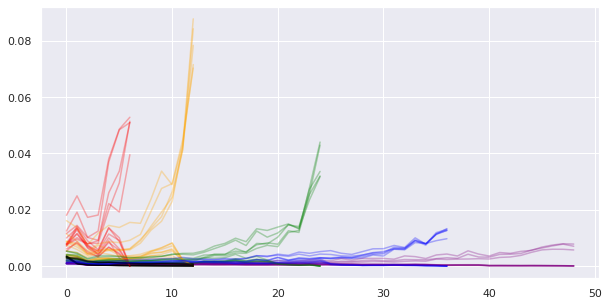

In [10]:
plt.figure(figsize=(10,5))
for f in filter(lambda x: 'indirect' in x, data_agg):
    if 'distil' in f:
        color = 'red'
    elif 'medium' in f:
        color = 'green'
    elif 'large' in f:
        color = 'blue'
    elif 'xl' in f:
        color = 'purple'
    elif 'random' in f:
        color = 'black'
    else:
        color = 'orange'
    df = data_agg[f]
    idx = data_top5[f]
    effects = (
        df.loc[idx]
        .sort_values('layer')
        .reset_index()
        .groupby('layer')
        .mean().effect_mean
    )
    plt.plot(
        effects,
        label=f[:-8].replace('_',' '), alpha=0.3, color=color,
    )
# plt.legend()
plt.show()

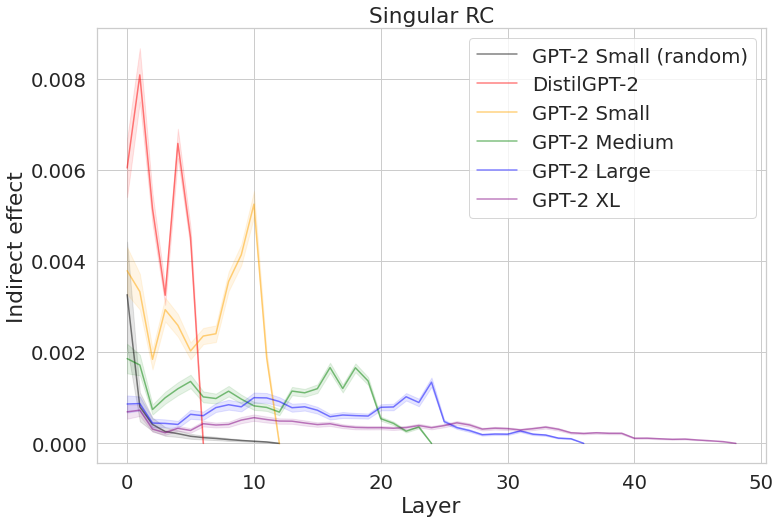

In [11]:
lines_sizes = []
for size in ('gpt2-random', 'distilgpt2', 'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'):
    lines_sizes.extend([
    #    (f'none_indirect_{size}.feather',         'orange',    'Simple Agreement', size, '-')])
    #    (f'distractor_indirect_{size}.feather',   'green', '2 distractors', size, '-')])
    #    (f'distractor_1_indirect_{size}.feather', 'green', '1 distractor', size, '--')])
    #    (f'singular_indirect_{size}.feather',     'blue',  'Singular PP', size,  '-')])
    #    (f'plural_indirect_{size}.feather',       'blue',  'Plural PP', size, '--')])
        ('_'.join(['rc_singular', 'indirect', f'{size}.feather']), 'purple', 'Singular RC', size, '-')])
    #    ('_'.join(['rc_plural',   'indirect', f'{size}.feather']), 'purple', 'Plural RC', size,  '-')])
    #    ('_'.join(['within_rc_singular', 'indirect', f'{size}.feather']), 'red', 'Within singular RC', size, '-')])
    #    ('_'.join(['within_rc_plural',   'indirect', f'{size}.feather']), 'red', 'Within plural RC',  size, '--')])
    #])

sns.set(font_scale=1.8)
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
for f, c, structure, size, linestyle in lines_sizes:
    if 'distil' in size:
        color = 'red'
        label = 'DistilGPT-2'
    elif 'medium' in size:
        color = 'green'
        label = 'GPT-2 Medium'
    elif 'large' in size:
        color = 'blue'
        label = 'GPT-2 Large'
    elif 'xl' in size:
        color = 'purple'
        label = 'GPT-2 XL'
    elif 'random' in size:
        color = 'black'
        label = 'GPT-2 Small (random)'
    else:
        color = 'orange'
        label = 'GPT-2 Small'
    df = data_agg[f].loc[data_top5[f]].sort_values('layer').reset_index()
    effect_mean = df.groupby('layer').mean().effect_mean
    effect_std = df.groupby('layer').mean().effect_sem
    if linestyle == '--':
        dashes = (5, 10)
    else:
        dashes = ()
    plt.plot(
        df.layer.unique(), 
        effect_mean,
        label=label, linestyle=linestyle, alpha=0.5, color=color
    )
    plt.fill_between(
        df.layer.unique(),
        effect_mean + effect_std,
        effect_mean - effect_std,
        color=color,
        alpha=0.1
    )
    plt.title(structure)
# plt.ylim([-0.001, 0.05])
plt.xlabel('Layer')
plt.ylabel('Indirect effect')
leg = plt.legend()
plt.savefig('../rc_singular.pdf', bbox_inches='tight')

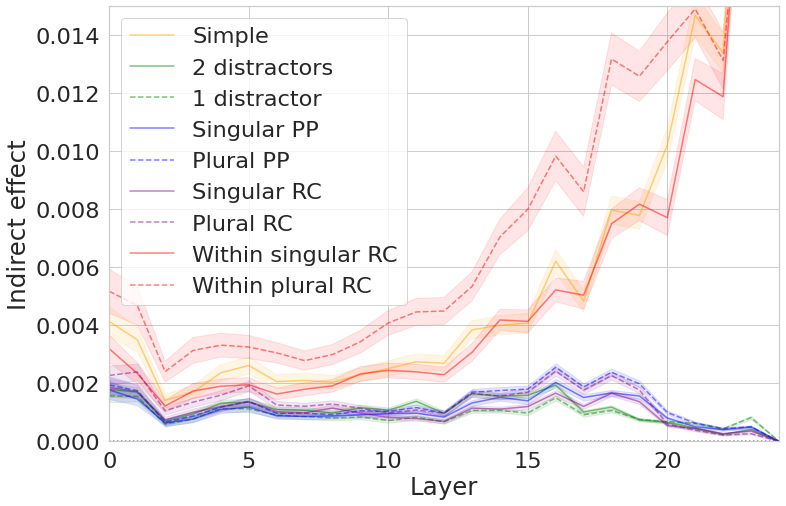

In [12]:
lines = [
    ('none_indirect_gpt2-medium.feather',         'orange',    'Simple', '-'),
    ('distractor_indirect_gpt2-medium.feather',   'green', '2 distractors', '-'),
    ('distractor_1_indirect_gpt2-medium.feather', 'green', '1 distractor',  '--'),
    ('singular_indirect_gpt2-medium.feather',     'blue',  'Singular PP',   '-'),
    ('plural_indirect_gpt2-medium.feather',       'blue',  'Plural PP',     '--'),
    ('_'.join(['rc_singular', 'indirect', 'gpt2-medium.feather']), 'purple', 'Singular RC', '-'),
    ('_'.join(['rc_plural',   'indirect', 'gpt2-medium.feather']), 'purple', 'Plural RC',   '--'),
    ('_'.join(['within_rc_singular', 'indirect', 'gpt2-medium.feather']), 'red', 'Within singular RC', '-'),
    ('_'.join(['within_rc_plural',   'indirect', 'gpt2-medium.feather']), 'red', 'Within plural RC',   '--'),
]

sns.set(font_scale=2.04)
sns.set_style('whitegrid')

plt.figure(figsize=(12,8))
for f, color, label, linestyle in lines:
    df = data_agg[f].loc[data_top5[f]].sort_values('layer').reset_index()
    effect_mean = df.groupby('layer').mean().effect_mean
    effect_std = df.groupby('layer').mean().effect_sem
    if linestyle == '--':
        dash_style = (5, 10)
        plt.plot(
            df.layer.unique(), 
            effect_mean,
            label=label, color=color, linestyle=linestyle, alpha=0.5,
            dashes=dash_style
        )
    else:
        plt.plot(
            df.layer.unique(), 
            effect_mean,
            label=label, color=color, linestyle=linestyle, alpha=0.5,
        )
    plt.fill_between(
        df.layer.unique(),
        effect_mean + effect_std,
        effect_mean - effect_std,
        alpha=0.1, color=color
    )
leg = plt.legend()
# bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
# bb.x0 += 0.02
# bb.x1 += 0.02
# leg.set_bbox_to_anchor(bb, transform = ax.transAxes)
# plt.title('Indirect effects of top 5% of neurons by layer')
plt.xlabel('Layer')
plt.ylabel('Indirect effect')
plt.ylim([0.0, 0.015])
plt.hlines(0, 0, 24, color='black', alpha=0.5, linestyle='dotted')
plt.xlim([0,24])
plt.savefig('../top5.pdf', bbox_inches='tight')
plt.show()

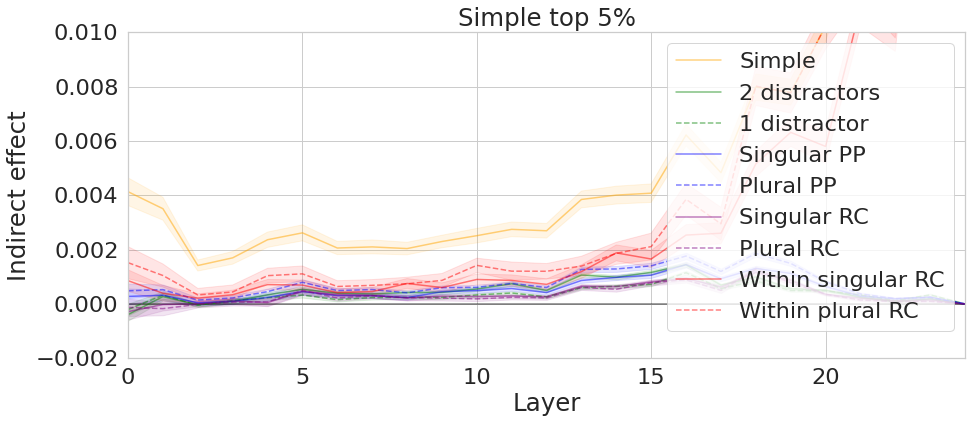

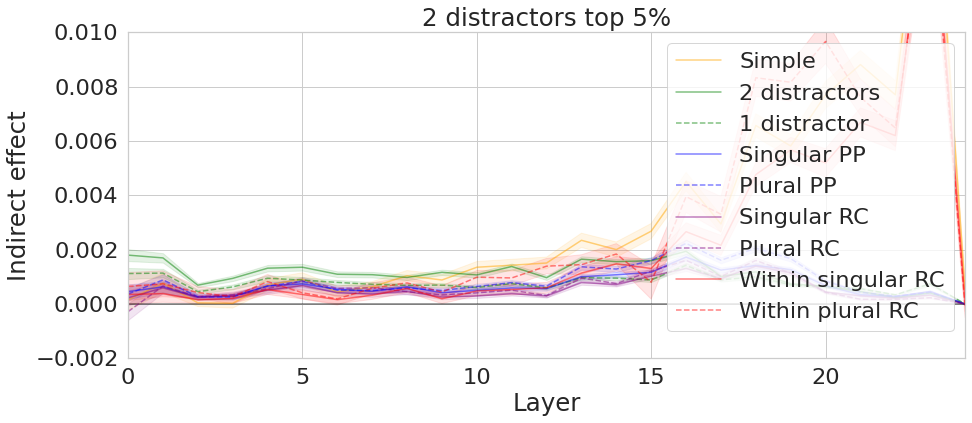

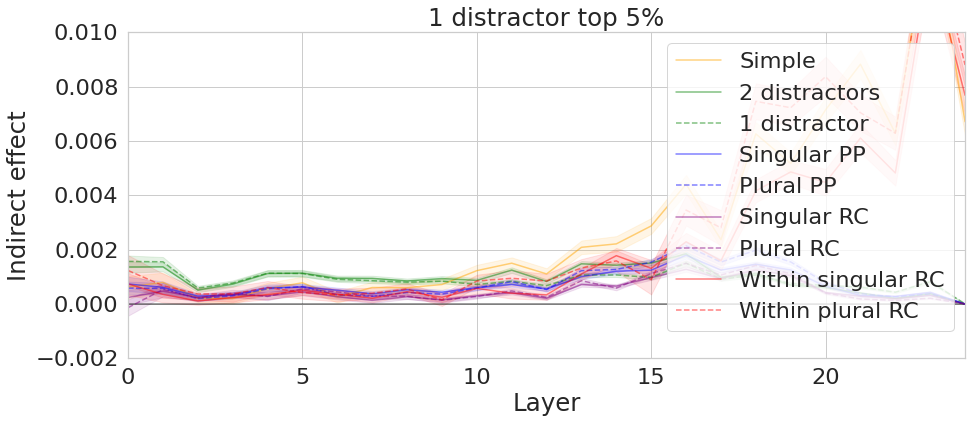

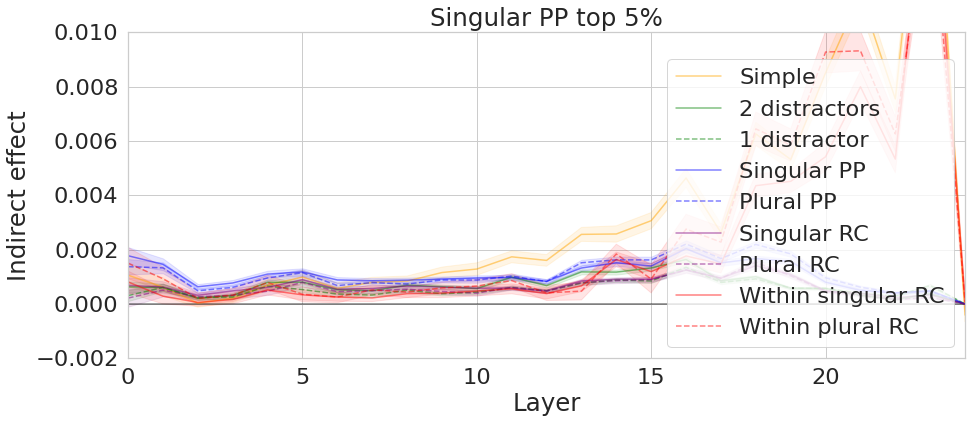

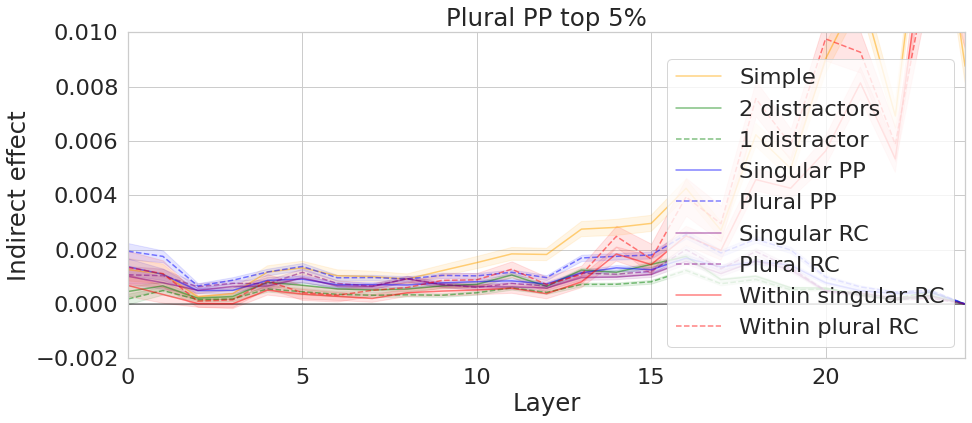

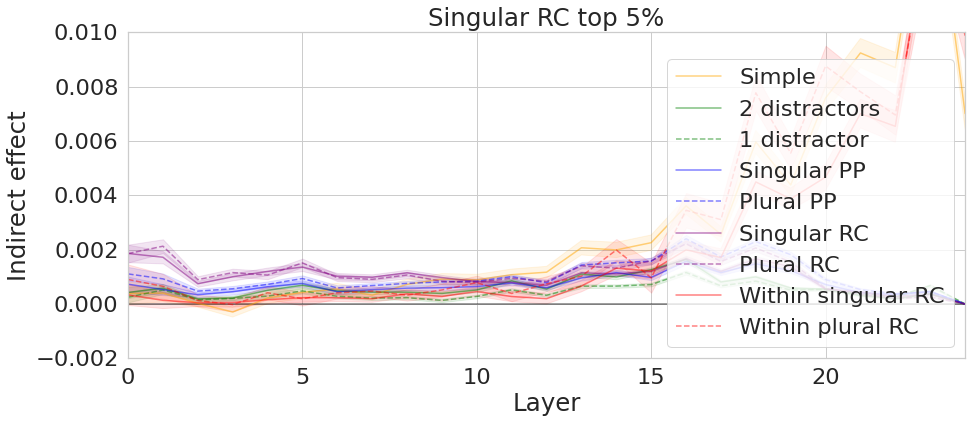

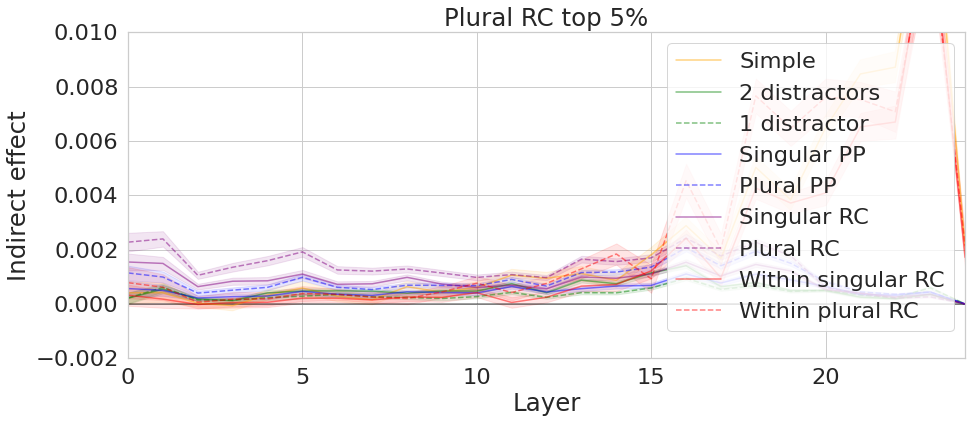

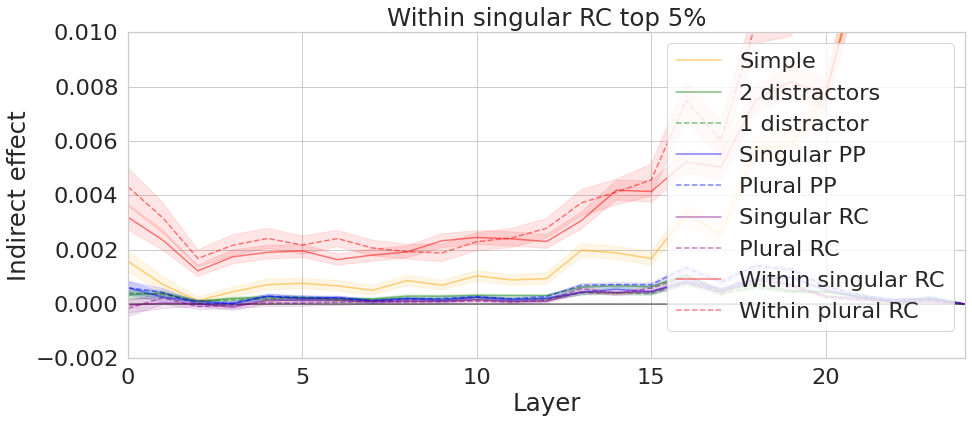

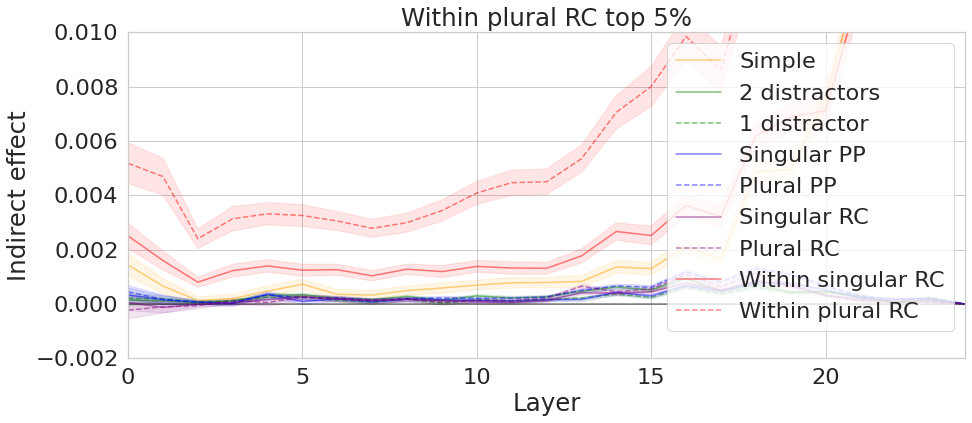

In [13]:
for g, _, title, _ in lines:
    plt.figure(figsize=(15,6))
    for f, color, label, linestyle in lines:
        df = data_agg[f].loc[data_top5[g]].sort_values('layer').reset_index()
        effect_mean = df.groupby('layer').mean().effect_mean
        effect_std = df.groupby('layer').mean().effect_sem
        plt.plot(
            df.layer.unique(), 
            effect_mean,
            label=label, color=color, linestyle=linestyle, alpha=0.5,
        )
        plt.fill_between(
            df.layer.unique(),
            effect_mean + effect_std,
            effect_mean - effect_std,
            alpha=0.1, color=color
        )
    plt.title(title + ' top 5%')
    plt.legend()
    plt.hlines(0, 0, 24, color='black', alpha=0.5)
    plt.xlim([0,24])
    plt.xlabel('Layer')
    plt.ylabel('Indirect effect')
    plt.ylim([-0.002, 0.01])
    # plt.savefig('../top5.pdf', bbox_inches='tight')
    plt.show()

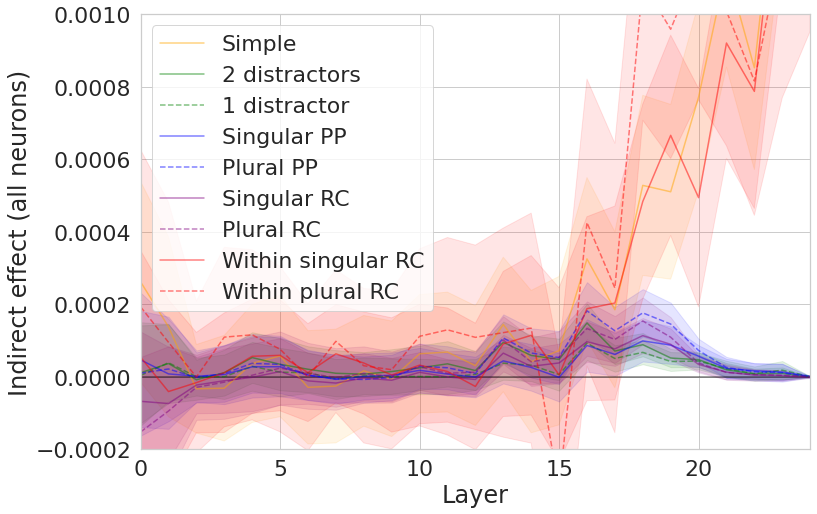

In [14]:
sns.set(font_scale=2.0)
sns.set_style('whitegrid')

plt.figure(figsize=(12,8))
for f, color, label, linestyle in lines:
    df = data_agg[f].sort_values('layer').reset_index()
    effect_mean = df.groupby('layer').mean().effect_mean
    effect_std = df.groupby('layer').mean().effect_sem
    plt.plot(
        df.layer.unique(), 
        effect_mean,
        label=label, color=color, linestyle=linestyle, alpha=0.5,
    )
    plt.fill_between(
        df.layer.unique(),
        effect_mean + effect_std,
        effect_mean - effect_std,
        alpha=0.1, color=color
    )
plt.legend()
plt.xlabel('Layer')
plt.ylabel('Indirect effect (all neurons)')
plt.ylim([-0.0002, 0.001])
plt.hlines(0, 0, 24, color='black', alpha=0.5)
plt.xlim([0,24])
plt.savefig('../allneurons.pdf', bbox_inches='tight')
plt.show()

In [15]:
data_agg[f].iloc[200]

effect_mean                            0.002704
effect_std                             0.005717
effect_sem                             0.000404
singular_grammaticality_mean           0.274619
singular_grammaticality_std            0.335955
singular_grammaticality_sem            0.023756
plural_grammaticality_mean             0.007932
plural_grammaticality_std              0.009146
plural_grammaticality_sem              0.000647
inv_singular_grammaticality_mean      13.498625
inv_singular_grammaticality_std       19.987312
inv_singular_grammaticality_sem        1.413316
inv_plural_grammaticality_mean       327.674767
inv_plural_grammaticality_std        395.512022
inv_plural_grammaticality_sem         27.966923
total_effect_mean                   3049.525111
total_effect_std                    6072.701853
total_effect_sem                     429.404866
Name: (0, 200), dtype: float64

100%|██████████| 45/45 [00:00<00:00, 2324.89it/s]


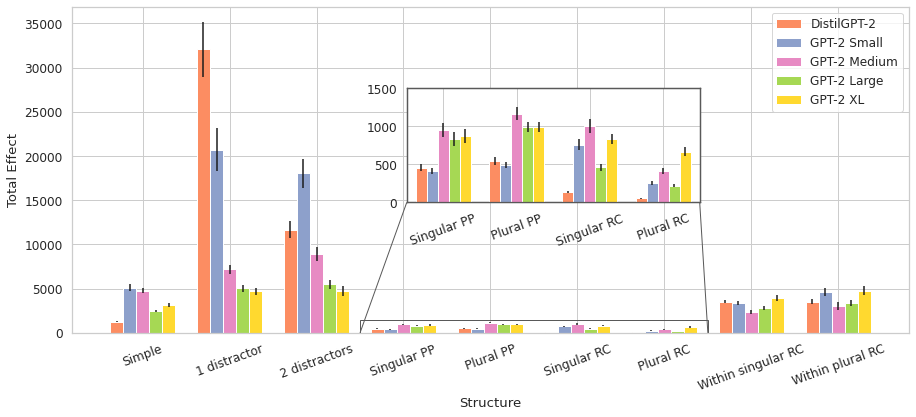

In [29]:
sns.set(font_scale=1.1)
sns.set_style('whitegrid')

size_to_name = {
    'distilgpt2': 'DistilGPT-2',
    'gpt2': 'GPT-2 Small',
    'gpt2-random': 'GPT-2 Small (random)',
    'gpt2-medium': 'GPT-2 Medium',
    'gpt2-large': 'GPT-2 Large',
    'gpt2-xl': 'GPT-2 XL'
}

lines_allsizes = []
for size in ('distilgpt2', 'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'):
    lines_allsizes.extend([
        (f'none_indirect_{size}.feather',         'orange',    'Simple', size, '-'),
        (f'distractor_1_indirect_{size}.feather', 'green', '1 distractor', size, '--'),
        (f'distractor_indirect_{size}.feather',   'green', '2 distractors', size, '-'),
        (f'singular_indirect_{size}.feather',     'blue',  'Singular PP', size,  '-'),
        (f'plural_indirect_{size}.feather',       'blue',  'Plural PP', size, '--'),
        ('_'.join(['rc_singular', 'indirect', f'{size}.feather']), 'purple', 'Singular RC', size, '-'),
        ('_'.join(['rc_plural',   'indirect', f'{size}.feather']), 'purple', 'Plural RC', size,  '--'),
        ('_'.join(['within_rc_singular', 'indirect', f'{size}.feather']), 'red', 'Within singular RC', size, '-'),
        ('_'.join(['within_rc_plural',   'indirect', f'{size}.feather']), 'red', 'Within plural RC',  size, '--'),
    ])

# get color palette
from pylab import *
cmap = cm.get_cmap('Set2')
colors = []

for i in range(1, cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    colors.append(matplotlib.colors.rgb2hex(rgba))

# plt.figure()
fig, ax = plt.subplots(figsize=(15,6))
labels = ['Simple', '1 distractor', '2 distractors', 'Singular PP', 'Plural PP', 'Singular RC', 
    'Plural RC', 'Within singular RC', 'Within plural RC']
bars   = defaultdict(list)
errors = defaultdict(list)
for f, color, label, size, linestyle in tqdm(lines_allsizes):
    # labels.append(label)
    bars[size].append(data_agg[f].iloc[0].total_effect_mean)
    errors[size].append(data_agg[f].iloc[0].total_effect_sem)

width = 0.15
x = np.arange(len(labels))
for idx, size in enumerate(bars.keys()):
    ax.bar(x + width*idx, bars[size], width, yerr=errors[size], label=size_to_name[size], color=colors[idx])

plt.legend()
ax.set_xticks([x + (2.0*width) for x in range(len(labels))])
ax.set_xticklabels(labels, rotation=20)
plt.ylabel('Total Effect')
plt.xlabel('Structure')


# Draw a detail for singular PP through RC
from detail_helper import ZoomViewAxes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.transforms import Bbox
axins = ZoomViewAxes(ax, Bbox.from_bounds(0.4,0.4,0.35,0.35), ax.transAxes)
x1, x2, y1, y2 = 2.8, 6.8, 0, 1500
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
#plt.setp(axins.get_xticklabels(), visible=False)
axins.set_xticks([2.8, 3.3, 4.3, 5.3, 6.3, 6.8])
axins.set_xticklabels(["", "Singular PP", "Plural PP", "Singular RC", "Plural RC", ""], rotation=20)
axins.spines['bottom'].set_color('0.35')
axins.spines['top'].set_color('0.35')
axins.spines['left'].set_color('0.35')
axins.spines['right'].set_color('0.35')
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.35")
plt.draw()

plt.savefig("../totaleffect.pdf", bbox_inches="tight")
plt.show()

100%|██████████| 40/40 [00:00<00:00, 2284.73it/s]


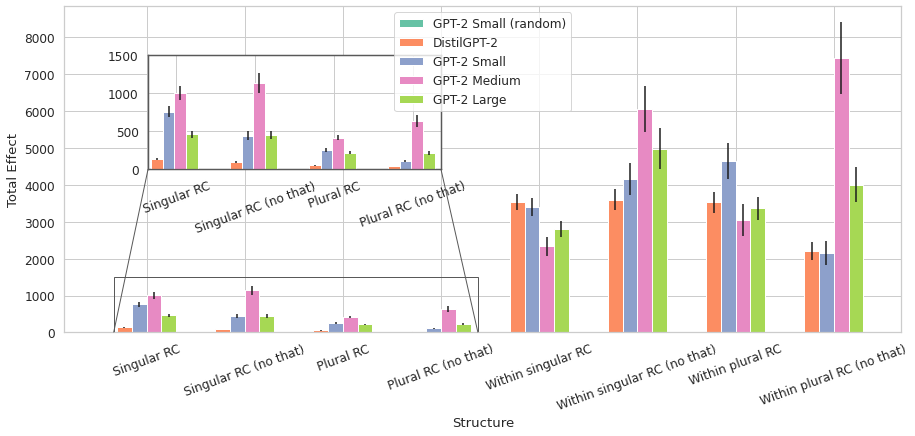

In [39]:
sns.set(font_scale=1.1)
sns.set_style('whitegrid')

size_to_name = {
    'distilgpt2': 'DistilGPT-2',
    'gpt2': 'GPT-2 Small',
    'gpt2-random': 'GPT-2 Small (random)',
    'gpt2-medium': 'GPT-2 Medium',
    'gpt2-large': 'GPT-2 Large',
    'gpt2-xl': 'GPT-2 XL'
}

lines_nothat = []
for size in ('gpt2-random', 'distilgpt2', 'gpt2', 'gpt2-medium', 'gpt2-large'):
    lines_nothat.extend([
        ('_'.join(['rc_singular', 'indirect', f'{size}.feather']), 'purple', 'Singular RC', size, '-'),
        ('_'.join(['rc_singular_no_that', 'indirect', f'{size}.feather']), 'purple', 'Singular RC', size, '-'),
        ('_'.join(['rc_plural',   'indirect', f'{size}.feather']), 'purple', 'Plural RC', size,  '--'),
        ('_'.join(['rc_plural_no_that',   'indirect', f'{size}.feather']), 'purple', 'Plural RC', size,  '--'),
        ('_'.join(['within_rc_singular', 'indirect', f'{size}.feather']), 'red', 'Within singular RC', size, '-'),
        ('_'.join(['within_rc_singular_no_that', 'indirect', f'{size}.feather']), 'red', 'Within singular RC', size, '-'),
        ('_'.join(['within_rc_plural',   'indirect', f'{size}.feather']), 'red', 'Within plural RC',  size, '--'),
        ('_'.join(['within_rc_plural_no_that', 'indirect', f'{size}.feather']), 'red', 'Within singular RC', size, '--'),
    ])

# get color palette
from pylab import *
cmap = cm.get_cmap('Set2')
colors = []

for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    colors.append(matplotlib.colors.rgb2hex(rgba))

# plt.figure()
fig, ax = plt.subplots(figsize=(15,6))
labels = ['Singular RC', 'Singular RC (no that)',
    'Plural RC', 'Plural RC (no that)', 'Within singular RC', 'Within singular RC (no that)',
    'Within plural RC', 'Within plural RC (no that)']
bars   = defaultdict(list)
errors = defaultdict(list)
for f, color, label, size, linestyle in tqdm(lines_nothat):
    # labels.append(label)
    bars[size].append(data_agg[f].iloc[0].total_effect_mean)
    errors[size].append(data_agg[f].iloc[0].total_effect_sem)

width = 0.15
x = np.arange(len(labels))
for idx, size in enumerate(bars.keys()):
    ax.bar(x + width*idx, bars[size], width, yerr=errors[size], label=size_to_name[size], color=colors[idx])

plt.legend(loc='upper center')
ax.set_xticks([x + (2.5*width) for x in range(len(labels))])
ax.set_xticklabels(labels, rotation=20)
plt.ylabel('Total Effect')
plt.xlabel('Structure')


# Draw a detail for singular PP through RC
from detail_helper import ZoomViewAxes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.transforms import Bbox
axins = ZoomViewAxes(ax, Bbox.from_bounds(0.1,0.5,0.35,0.35), ax.transAxes)
x1, x2, y1, y2 = 0.04, 3.7, 0, 1500
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
#plt.setp(axins.get_xticklabels(), visible=False)
axins.set_xticks([0.04, 0.4, 1.4, 2.4, 3.4, 3.75])
axins.set_xticklabels(["", "Singular RC", "Singular RC (no that)", "Plural RC", "Plural RC (no that)", ""], rotation=20)
axins.spines['bottom'].set_color('0.35')
axins.spines['top'].set_color('0.35')
axins.spines['left'].set_color('0.35')
axins.spines['right'].set_color('0.35')
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.35")
plt.draw()


plt.savefig("../totaleffect_nocomp.pdf", bbox_inches="tight")
plt.show()


100%|██████████| 16/16 [00:00<00:00, 2328.63it/s]


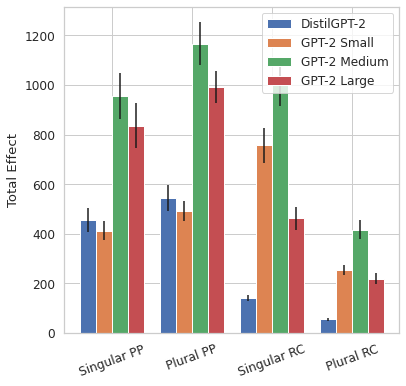

In [17]:
lines_allsizes_subset = []
for size in ('distilgpt2', 'gpt2', 'gpt2-medium', 'gpt2-large'):
    lines_allsizes_subset.extend([
        (f'singular_indirect_{size}.feather',     'blue',  'Singular PP', size,  '-'),
        (f'plural_indirect_{size}.feather',       'blue',  'Plural PP', size, '--'),
        ('_'.join(['rc_singular', 'indirect', f'{size}.feather']), 'purple', 'Singular RC', size, '-'),
        ('_'.join(['rc_plural',   'indirect', f'{size}.feather']), 'purple', 'Plural RC', size,  '--')
    ])

fig, ax = plt.subplots(figsize=(6,6))
# plt.figure()
labels = ['Singular PP', 'Plural PP', 'Singular RC', 'Plural RC']
bars   = defaultdict(list)
errors = defaultdict(list)
for f, color, label, size, linestyle in tqdm(lines_allsizes_subset):
    # labels.append(label)
    bars[size].append(data_agg[f].iloc[0].total_effect_mean)
    errors[size].append(data_agg[f].iloc[0].total_effect_sem)

width = 0.2
x = np.arange(len(labels))
for idx, size in enumerate(bars.keys()):
    ax.bar(x + width*idx, bars[size], width, yerr=errors[size], label=size_to_name[size])

plt.legend()
ax.set_xticks([x + (1.5*width) for x in range(len(labels))])
ax.set_xticklabels(labels, rotation=20)
plt.ylabel('Total Effect')
# plt.xlabel('Structure')
plt.show()

In [18]:
# fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15,6))
lines = [
    ('none_indirect_gpt2-medium.feather',         'orange',    'Simple', '-'),
    ('distractor_indirect_gpt2-medium.feather',   'red', '2 distractors', '-'),
    ('distractor_1_indirect_gpt2-medium.feather', 'red', '1 distractor',  '--'),
    ('singular_indirect_gpt2-medium.feather',     'green',  'Singular PP',   '-'),
    ('plural_indirect_gpt2-medium.feather',       'green',  'Plural PP',     '--'),
    ('_'.join(['rc_singular', 'indirect', 'gpt2-medium.feather']), 'blue', 'Singular RC', '-'),
    ('_'.join(['rc_plural',   'indirect', 'gpt2-medium.feather']), 'blue', 'Plural RC',   '--'),
    ('_'.join(['within_rc_singular', 'indirect', 'gpt2-medium.feather']), 'purple', 'Within singular RC', '-'),
    ('_'.join(['within_rc_plural',   'indirect', 'gpt2-medium.feather']), 'purple', 'Within plural RC',   '--'),
]

labels = []
dfs = []
for f, color, label, linestyle in tqdm(lines):
    df = data_agg[f]
    df['label'] = label
    dfs.append(df)


100%|██████████| 9/9 [00:00<00:00, 944.33it/s]


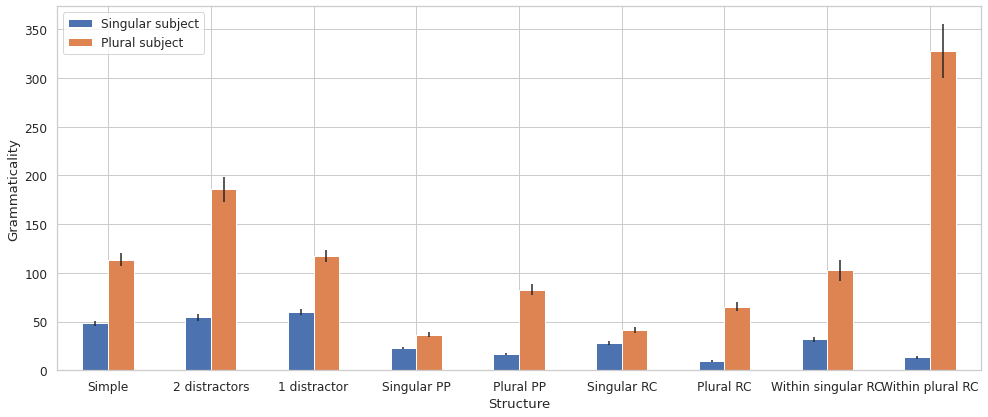

NameError: name 'plotit' is not defined

In [20]:
fig, ax = plt.subplots()
df = (
    pd.concat(dfs)
    .sort_index()
    .loc[0,0]
    .set_index('label')
    [[
        'inv_singular_grammaticality_mean','inv_plural_grammaticality_mean',
        'inv_singular_grammaticality_sem','inv_plural_grammaticality_sem'
    ]]
)
df[['inv_singular_grammaticality_mean','inv_plural_grammaticality_mean',]].plot.bar(
    figsize=(14, 6),
    rot=0,
    yerr=df[['inv_singular_grammaticality_sem', 'inv_plural_grammaticality_sem']].values.T,
    ax=ax
)
plt.xlabel('Structure')
# ax.set_xticklabels(rotation=20)
plt.ylabel('Grammaticality')
# ax.set_xticklabels(rotation=0.2)
ax.legend(['Singular subject', 'Plural subject'], loc='upper left')
plt.tight_layout()
# plt.title('Grammaticality by example type')
plt.show()
plotit

- [x] Within rc
- [ ] Show size dim for TE and NIE and Grammaticality
    - [x] NIE
- [x] Universally top neurons
- [ ] Heatmaps w/ normalized colors?

In [40]:
data['within_rc_plural_indirect_distilgpt2.feather']

,word,base_string,alt_string1,candidate1,candidate2,candidate1_base_prob,candidate2_base_prob,candidate1_alt1_prob,candidate2_alt1_prob,candidate1_prob,candidate2_prob,layer,neuron,singular_grammaticality,plural_grammaticality,yz,effect,total_effect,inv_singular_grammaticality,inv_plural_grammaticality
Unnamed: 0,,,,,,,,,,,,,,,,,,,,
0,The doctors that the {}_parent_avoids,The doctors that the parent,The doctors that the parents,['Ġavoids'],['Ġavoid'],2.969386e-05,2.581028e-05,2.571165e-07,8.697883e-05,2.926630e-05,2.597919e-05,0,0,0.869213,0.002956,0.887683,0.021249,388.186207,1.150466,338.285655
1,The doctors that the {}_parent_avoids,The doctors that the parent,The doctors that the parents,['Ġavoids'],['Ġavoid'],2.969386e-05,2.581028e-05,2.571165e-07,8.697883e-05,2.966997e-05,2.592030e-05,0,1,0.869213,0.002956,0.873621,0.005071,388.186207,1.150466,338.285655
2,The doctors that the {}_parent_avoids,The doctors that the parent,The doctors that the parents,['Ġavoids'],['Ġavoid'],2.969386e-05,2.581028e-05,2.571165e-07,8.697883e-05,2.978444e-05,2.579793e-05,0,2,0.869213,0.002956,0.866154,-0.003519,388.186207,1.150466,338.285655
3,The doctors that the {}_parent_avoids,The doctors that the parent,The doctors that the parents,['Ġavoids'],['Ġavoid'],2.969386e-05,2.581028e-05,2.571165e-07,8.697883e-05,2.704677e-05,2.451090e-05,0,3,0.869213,0.002956,0.906241,0.042600,388.186207,1.150466,338.285655
4,The doctors that the {}_parent_avoids,The doctors that the parent,The doctors that the parents,['Ġavoids'],['Ġavoid'],2.969386e-05,2.581028e-05,2.571165e-07,8.697883e-05,2.909759e-05,2.573797e-05,0,4,0.869213,0.002956,0.884539,0.017633,388.186207,1.150466,338.285655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075195,The lawyers that the {}_dancer_stimulates,The lawyers that the dancer,The lawyers that the dancers,['Ġstimulates'],['Ġstimulate'],2.056094e-07,2.103175e-08,4.198728e-09,3.306174e-07,2.054787e-07,2.104019e-08,6,763,0.102290,0.012700,0.102396,0.001038,768.796083,9.776146,78.742287
1075196,The lawyers that the {}_dancer_stimulates,The lawyers that the dancer,The lawyers that the dancers,['Ġstimulates'],['Ġstimulate'],2.056094e-07,2.103175e-08,4.198728e-09,3.306174e-07,2.062299e-07,2.101522e-08,6,764,0.102290,0.012700,0.101902,-0.003792,768.796083,9.776146,78.742287
1075197,The lawyers that the {}_dancer_stimulates,The lawyers that the dancer,The lawyers that the dancers,['Ġstimulates'],['Ġstimulate'],2.056094e-07,2.103175e-08,4.198728e-09,3.306174e-07,2.034107e-07,2.104263e-08,6,765,0.102290,0.012700,0.103449,0.011332,768.796083,9.776146,78.742287
